In [1]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import lmfit
from scipy import optimize as opt
from IPython.display import clear_output
#import csv

In [2]:
model_str = '''
    model dosingmodel()
    //Time is in days!
    
    //infusion
    
    -> Dpls; switch * infusion_amount / one_our // switch = (0,1) to turn on or off, infusion happens over 1h
    
    //flow from plasma 
    
    Dpls -> ; kE0 * Dpls // elimination
    
    Dpls -> Dperi ; kp * Dpls // to periphery 
    
    Dpls -> Dlung ; k0 * Dpls
    
    // flow from periphery
    
    Dperi -> Dpls ; kpp * Dpls // to plasma 
    
    // Drug reactions / flow in lung
    
    Dlung -> Dpls ; k0 * Dlung
    
    Dlung -> Mala ; k12 * Dlung
    
    Dlung -> ; kE1 * Dlung
    
    // Mala reactions
    
    Mala -> Mnmp ; k23 * Mala
    
    Mala -> ; kE2 * Mala
    
    //Mnmp reactions
    
    Mnmp -> Mntp ; k34 * Mnmp
    Mnmp ->  ; kE3 * Mnmp
    
    // Mntp reaction
    
    Mntp -> ; kE4 * Mntp
    
    //parameters
    // initial conditions 
    
    //utils
    switch = 0 //turns infusion on/off
    curr_infu_start = 0 // tracks when current infusion started
    
    // rates
    
    kp = 0.41195
    
    kpp = 0.36502

    k0 = 6.3335
    
    k12 = 1.2248
    
    k23 = 372.61
    
    k34 = 181.64

    kE0 = 20.253
    
    kE1 = 7.81
    
    kE2 = 6.0801
    
    kE3 = 0.97259
    
    kE4 = 0.83115

    //constants
    infusion_amount = 1
    
    dose_interval = 1
    
    dose_end = 9999
    
    one_our = 1/24 
    
    first_dose = 0
    
    // events
    
    E1: at (time - first_dose > 0): switch = 1, curr_infu_start = time ; // starts the first infusion
    //E2: at ( (time-first_dose > dose_interval) && (time < dose_end) && sin((((time-first_dose)/dose_interval))*2*pi)>0): switch = 1, curr_infu_start = time; // starts the subsequent infusions
    E3: at (time - (one_our + curr_infu_start) > 0): switch = 0 ; // turns infusion off
    
    end
'''


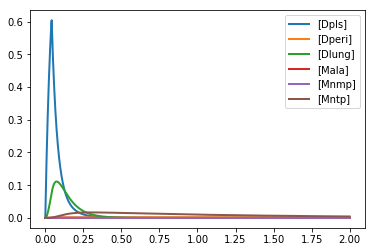

In [3]:

r = te.loada(model_str)
r.simulate(0, 2, 1000)
r.plot()

In [4]:
compartments_model_str = '''
    model dosingmodel()
    //Time is in hours!
    
    // compartments
    
    compartment L; //lungs
    L = 6.0 // volume of L
    
    
    compartment P; // plasma
    P = 3.0
    
    compartment B; // rest of body
    B = 90.0
    
    // species
    
    species Dpls, Dperi, Dlung, Mala, Mnmp, Mntp;
    
    Dpls in P;
    
    Dperi in B;
    
    Dlung in L;
    
    Mala in L;
    
    Mnmp in L;
    
    Mntp in L;
        
    //infusion    
    J0: -> Dpls; switch * infusion_amount / one_our // switch = (0,1) to turn on or off, infusion happens over 1h    
    //flow from plasma     
    J1: Dpls -> ; kE0 * Dpls // elimination    
    J2: Dpls -> Dperi ; kp * Dpls // to periphery     
    J3: Dpls -> Dlung ; k01 * Dpls
        
    // flow from periphery    
    J4: Dperi -> Dpls ; kpp * Dpls // to plasma     
    
    // Drug reactions / flow in lung    
    J5: Dlung -> Dpls ; k10 * Dlung    
    J6: Dlung -> Mala ; k12 * Dlung    
    J7: Dlung -> ; kE1 * Dlung
    
    // Mala reactions    
    J8: Mala -> Mnmp ; k23 * Mala    
    J9: Mala -> ; kE2 * Mala
    
    //Mnmp reactions    
    J10: Mnmp -> Mntp ; k34 * Mnmp
    J11: Mnmp ->  ; kE3 * Mnmp
    
    // Mntp reaction    
    J12: Mntp -> ; kE4 * Mntp
    
    
    //parameters
    // initial conditions 
    
    //utils
    switch = 0 //turns infusion on/off
    curr_infu_start = 0 // tracks when current infusion started
    
    // rates
    
    kp = 1
    
    kpp = 1
    
    k01 = 6.3335 / 24    
    k10 = 6.3335 / 24
        
    k12 = 1.2248 / 24
    
    k23 = 372.61 / 24
    
    k34 = 181.64 / 24

    kE0 = 20.253 / 24
    
    kE1 = 7.81 / 24
    
    kE2 = 6.0801 / 24
    
    kE3 = 0.97259 / 24
    
    kE4 = 0.83115 / 24

    //constants
    infusion_amount = 2.82630816e+03
    
    dose_interval = 1
    
    dose_end = 9999
    
    one_our = 1
    
    first_dose = 0
    
    // events
     //E1: at (time - first_dose > 0): switch = 1, curr_infu_start = time ; // starts the first infusion
    //E2: at ( (time-first_dose > dose_interval) && (time < dose_end) && sin((((time-first_dose)/dose_interval))*2*pi)>0): switch = 1, curr_infu_start = time; // starts the subsequent infusions
    //E3: at (time - (one_our + curr_infu_start) > 0): switch = 0 ; // turns infusion off
    E4: at (time - one_our + curr_infu_start > 0): Dpls = infusion_amount ;
    
    end
'''


In [5]:

# nr = te.loada(compartments_model_str)
# rnr = nr.simulate(data[0,0], 1.1*data[-1,0], len(data[:,0])*1000)
# nr.plot()
# nr = te.loada(compartments_model_str)
# nr.B = 1000000
# print(nr.B)
# rnr = nr.simulate(0, 3, 1000)
# nr.plot()


In [10]:
global fitted_params
fitted_params = {}
global data, var_to_fit
data = None
var_to_fit = None

In [12]:
def cost_fnc(p):
    if data is None or var_to_fit is None:
         return
    m = te.loada(compartments_model_str)
    param_values = p.valuesdict()    
    for key in p:
        m.model[key] = param_values[key]
    for key, value in fitted_params.items():
        m.model[key] = value
    try:
        sqdiff = 0
        s = m.simulate(data[0,0], 1.1*data[-1,0], len(data[:,0])*10000)
        for i in range(len(data[:,0])):
            j = (np.abs(s['time'] - data[i,0])).argmin()
#             print((np.abs(s['time'] - data[i,0])).argmin(), s['time'][j], data[i,0])
            if var_to_fit == '[Dpls]' and s[var_to_fit][j] < 1:
                continue
            sqdiff += (data[i,1] - s[var_to_fit][j])**2
        clear_output(wait=True)
        plt.plot(data[:,0],data[:,1], '.', label='Data '+ var_to_fit)
        plt.plot(s['time'], s[var_to_fit],label='Model')
        plt.legend(loc=1)
        plt.title('Chi-squared Error: %.2f' % sqdiff)
        plt.ylabel('Concentration')
        plt.xlabel('Time (hours)')
        plt.grid()
        plt.show()
    except RuntimeError:
        sqdiff = 1E21
        return sqdiff
    
    return np.sqrt(sqdiff)
    

In [13]:
plsm_params = lmfit.Parameters()
plsm_params.add('B', value = 90, min=40, max=130)
plsm_params.add('P', value = 3, min=2, max=4)
plsm_params.add('L', value = 6, min=4, max=8)

kE0_init_guess = 20.253 / 24
plsm_params.add('kE0', value = kE0_init_guess, min = 0)

kE1_init_guess = 7.81 / 24
plsm_params.add('kE1', value = kE1_init_guess, min = 0)

k12_init_guess = 1.2248 / 24
plsm_params.add('k12', value = k12_init_guess, min = 0)

kp_init_guess = 1
plsm_params.add('kp', value = kp_init_guess, min = 0)

kpp_init_guess = 1
plsm_params.add('kpp', value = kpp_init_guess, min = 0)

k01 = 6.3335 / 24    
plsm_params.add('k01', value = k01, min = 0)

k10 = 6.3335 / 24
plsm_params.add('k10', value = k10, min = 0)


# infusion_amount = 10000
# plsm_params.add('infusion_amount', value = infusion_amount)

# v = plsm_params.valuesdict()
# v['B']

# for key in plsm_params:
#     print(key)
#     print(v[key])

In [14]:
rmds_data = np.loadtxt(open('rdv-graph-fig2.csv', 'r'), delimiter=",")
cost_fnc(plsm_params)

In [15]:
global data, var_to_fit
data = rmds_data
var_to_fit = '[Dpls]'
plsm_minimizer = lmfit.Minimizer(cost_fnc, plsm_params)
# plsm_minimizer = opt.minimize(cost_fnc, params)


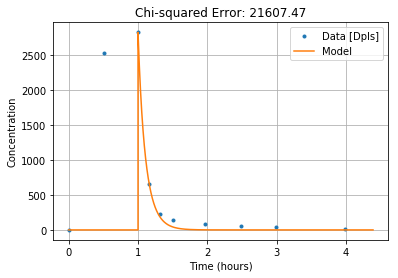

In [16]:
# result = plsm_minimizer.minimize(method='dual_annealing')
fitted_params = {}
result = plsm_minimizer.minimize(method='nelder')

In [17]:
plsm_fit_result = result

In [18]:
fitted_params['B'] = plsm_fit_result.params['B'].value
fitted_params['P'] = plsm_fit_result.params['P'].value
fitted_params['L'] = plsm_fit_result.params['L'].value

fitted_params['kE0'] = plsm_fit_result.params['kE0'].value
fitted_params['kE1'] = plsm_fit_result.params['kE1'].value

fitted_params['k12'] = plsm_fit_result.params['k12'].value
fitted_params['kp'] = plsm_fit_result.params['kp'].value
fitted_params['kpp'] = plsm_fit_result.params['kpp'].value
print(fitted_params)

{'B': 129.63594697393683, 'P': 3.229906096861619, 'L': 7.035319143652125, 'kE0': 77.12144475098854, 'kE1': 96.06902969975401, 'k12': 9.817062031227053, 'kp': 107.51576564797482, 'kpp': 191.52460881790898}


In [22]:
# first_fit = fitted_params.copy()
# fitted_params = {}
first_fit

{'B': 129.63594697393683,
 'P': 3.229906096861619,
 'L': 7.035319143652125,
 'kE0': 77.12144475098854,
 'kE1': 96.06902969975401,
 'k12': 9.817062031227053,
 'kp': 107.51576564797482,
 'kpp': 191.52460881790898}

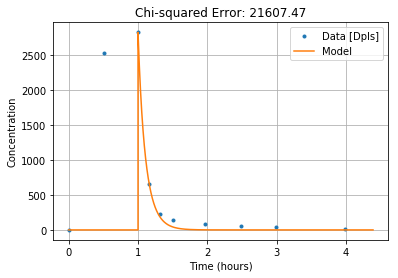

In [27]:
plsm_params = lmfit.Parameters()
plsm_params.add('B', value = 90, min=60, max=110)
plsm_params.add('P', value = 3, min=2, max=4)
plsm_params.add('L', value = 6, min=4, max=8)

kE0_init_guess = 20.253 / 24
plsm_params.add('kE0', value = kE0_init_guess, min = 0)

kE1_init_guess = 7.81 / 24
plsm_params.add('kE1', value = kE1_init_guess, min = 0)

k12_init_guess = 1.2248 / 24
plsm_params.add('k12', value = k12_init_guess, min = 0)

kp_init_guess = 1
plsm_params.add('kp', value = kp_init_guess, min = 0)

kpp_init_guess = 1
plsm_params.add('kpp', value = kpp_init_guess, min = 0)

k01 = 6.3335 / 24    
plsm_params.add('k01', value = k01, min = 0)

k10 = 6.3335 / 24
plsm_minimizer = lmfit.Minimizer(cost_fnc, plsm_params)
plsm_params.add('k10', value = k10, min = 0)
result = plsm_minimizer.minimize(method='nelder')

In [28]:
plsm_2nd_fit = {}
plsm_2nd_fit['B'] = result.params['B'].value
plsm_2nd_fit['P'] = result.params['P'].value
plsm_2nd_fit['L'] = result.params['L'].value

plsm_2nd_fit['kE0'] = result.params['kE0'].value
plsm_2nd_fit['kE1'] = result.params['kE1'].value

plsm_2nd_fit['k12'] = result.params['k12'].value
plsm_2nd_fit['kp'] = result.params['kp'].value
plsm_2nd_fit['kpp'] = result.params['kpp'].value
print(plsm_2nd_fit)

{'B': 69.42985308484634, 'P': 3.229906096861619, 'L': 7.035319143652125, 'kE0': 77.12144475098854, 'kE1': 96.06902969975401, 'k12': 9.817062031227053, 'kp': 107.51576564797482, 'kpp': 191.52460881790898}


In [30]:
fitted_params = plsm_2nd_fit.copy()
fitted_params

{'B': 69.42985308484634,
 'P': 3.229906096861619,
 'L': 7.035319143652125,
 'kE0': 77.12144475098854,
 'kE1': 96.06902969975401,
 'k12': 9.817062031227053,
 'kp': 107.51576564797482,
 'kpp': 191.52460881790898}

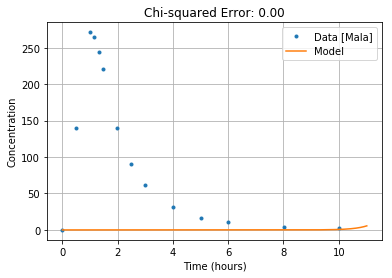

/apps/share64/debian7/anaconda/anaconda3-5.1/lib/python3.6/site-packages/lmfit/minimizer.py:339: RuntimeWarning:

divide by zero encountered in log



In [33]:
Mala_data = np.loadtxt(open('gs-704277-graph-fig2.csv', 'r'), delimiter=",")
data = Mala_data
var_to_fit = '[Mala]'

mala_params = lmfit.Parameters()

k01 = 6.3335 / 24
mala_params.add('k01', value = k01, min = 0)

k10 = 6.3335 / 24
mala_params.add('k01', value = k10, min = 0)

k23 = 372.61 / 24
mala_params.add('k23', value = k23, min = 0)

kE2 = 6.0801 / 24
mala_params.add('kE2', value = kE2, min = 0)

mala_minimizer = lmfit.Minimizer(cost_fnc, mala_params)
result = mala_minimizer.minimize(method='nelder')

In [32]:
Mala_data

array([[  0.        ,   0.        ],
       [  0.475351  , 139.48952469],
       [  0.98425511, 271.24723515],
       [  1.14161749, 265.15357169],
       [  1.30703969, 244.77003056],
       [  1.48040435, 220.83754639],
       [  1.97741435, 139.74240746],
       [  2.4822103 ,  90.47692976],
       [  2.99467483,  62.03362019],
       [  4.00364072,  31.23547083],
       [  4.9967217 ,  16.4649784 ],
       [  5.98909843,  10.66660331],
       [  8.0053087 ,   4.47685033],
       [ 10.012481  ,   2.64952489]])